<a href="https://colab.research.google.com/github/Usmanrajaa/ElectricityDemandForecasting/blob/master/Copy_of_Fashion_recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import random
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/DATASETS/Recommendations based on  Amazon Women Shirts data.csv')


In [ ]:
data.head(10)

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images/I/31VspXbakvL._SL160_.jpg,SHIRT,featherlite ladies long sleeve stain resistant tapered twill shirt 2xl onyx black stone,$26.26
1,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images/I/41EpudaOiWL._SL160_.jpg,SHIRT,womens unique 100 cotton special olympics world games 2015 white size l,$9.99
2,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images/I/41dCf%2BplpCL._SL160_.jpg,SHIRT,featherlite ladies moisture free mesh sport shirt white xxxlarge,$20.54
3,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images/I/41Cn7jZ3O9L._SL160_.jpg,SHIRT,supernatural chibis sam dean castiel neck tshirts female purple l,$7.39
4,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images/I/51CrsFle7%2BL._SL160_.jpg,SHIRT,fifth degree womens gold foil graphic tees junior top short sleeve printed shirt l,$6.95
5,B011YPK0MW,Feel The Piece,Navy,https://images-na.ssl-images-amazon.com/images/I/41jZnuCA6OL._SL160_.jpg,SHIRT,feel piece sami dip dye top one size navy,$72.40
6,B0079QXJ3S,FineBrandShop,Fuchsia,https://images-na.ssl-images-amazon.com/images/I/41eaHHtU%2ByL._SL160_.jpg,SHIRT,ladies fuchsia pink seamless stone set tube top,$7.50
7,B00R7DO9ZA,Finejo,white,https://images-na.ssl-images-amazon.com/images/I/410Sa3EZiLL._SL160_.jpg,SHIRT,finejo ladies sleeveless shirt lace shirts high low tops long blouses l,$11.99
8,B00BXOQ3X0,FeatherLite,Coffee Bean,https://images-na.ssl-images-amazon.com/images/I/31C%2BTk14fsL._SL160_.jpg,SHIRT,featherlite ladies silky smooth pique coffee bean,$12.91
9,B011JQWCCM,Ferrari,Red,https://images-na.ssl-images-amazon.com/images/I/41FPzxL7E%2BL._SL160_.jpg,SHIRT,puma womens ferrari big shield tee rosso corsa tshirt xl,$34.99


In [ ]:
data = data.loc[~data['formatted_price'].isnull()]
print('Number of data points After eliminating price=NULL :', data.shape[0])

data =data.loc[~data['color'].isnull()]
print('Number of data points After eliminating color=NULL :', data.shape[0])

Number of data points After eliminating price=NULL : 9391
Number of data points After eliminating color=NULL : 9391


In [ ]:
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

After removal of products with short description: 9352


In [ ]:
print('The number of entries with duplicate title is %d'%sum(data.duplicated('title')))
# Sort the whole data based on title (alphabetical order of title)
data_sorted.sort_values('title',inplace=True, ascending=False)

indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    previous_i = i
    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    a = data['title'].loc[indices[i]].split()
    # search for the similar products sequentially
    j = i+1
    while j < num_data_points:
        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'Small']
        b = data['title'].loc[indices[j]].split()
        # store the maximum length of two strings
        length = max(len(a), len(b))
        # count is used to store the number of words that are matched in both strings
        count  = 0
        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b):
            if (k[0] == k[1]):
                count += 1
        # if the number of words in which both strings differ are > 2 , we are considering it as those two apperals are different
        # if the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) > 2: # number of words in which both sensences differ
            # if both strings are differ by more than 2 words we include the 1st string index
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])
            # if the comaprision between is between num_data_points, num_data_points-1 strings and they differ in more than 2 words we include both
            if j == num_data_points-1: stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[j]])
            # start searching for similar apperals corresponds 2nd string
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

data = data.loc[data['asin'].isin(stage1_dedupe_asins)]
print('Number of data points now is: ', data.shape[0])

The number of entries with duplicate title is 0
Number of data points now is:  9222


In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string


list of stop words: {'my', 'theirs', 'and', 'when', 'yourself', "you'd", 'out', "hasn't", 'too', "needn't", 'haven', 'most', 'other', 'will', 'yours', "doesn't", 'been', 'shan', 't', 'her', 'wasn', 'each', 'why', 'him', 'shouldn', 'what', "aren't", 'mustn', 'or', 'having', "mightn't", 'should', 'because', 'off', 'm', 'these', 've', 'has', "it's", 'very', 'won', 'itself', "wasn't", 'while', 'she', 'did', 'himself', 'where', 'hasn', 'as', 'had', 'over', 'are', 'was', 'in', 'nor', 'yourselves', "didn't", 'this', 'any', 'am', 'during', 'now', 'more', 'can', "that'll", 'isn', 'ma', 'a', "don't", 're', 'from', 'who', 'up', 'myself', "she's", 'so', 'we', "couldn't", 'until', 'then', 'mightn', 'i', 'such', 'wouldn', 'them', 'the', 'again', 'our', "weren't", 'o', 'they', 'be', 'those', 'have', 'few', 'on', 'all', "shan't", 'how', 'some', 'needn', "should've", 'here', 'through', 'y', 'after', 'me', 'does', 'couldn', 'about', 'll', 'themselves', 'don', 'didn', "isn't", "won't", 'weren', 'hers', '

In [ ]:
data.head(5)

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images/I/31VspXbakvL._SL160_.jpg,SHIRT,featherlite ladies long sleeve stain resistant tapered twill shirt 2xl onyx black stone,$26.26
1,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images/I/41EpudaOiWL._SL160_.jpg,SHIRT,womens unique 100 cotton special olympics world games 2015 white size l,$9.99
2,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images/I/41dCf%2BplpCL._SL160_.jpg,SHIRT,featherlite ladies moisture free mesh sport shirt white xxxlarge,$20.54
3,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images/I/41Cn7jZ3O9L._SL160_.jpg,SHIRT,supernatural chibis sam dean castiel neck tshirts female purple l,$7.39
4,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images/I/51CrsFle7%2BL._SL160_.jpg,SHIRT,fifth degree womens gold foil graphic tees junior top short sleeve printed shirt l,$6.95


In [ ]:
data['digital']=False

In [ ]:
data['digital']=data['digital'].astype('bool')

In [ ]:
data['formatted_price']=data['formatted_price'].apply(lambda x:x.replace('$',''))

In [ ]:

import sys
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
data.drop(data.loc[data['formatted_price']=='1,129.99'].index, inplace=True)

In [ ]:
data.drop(data.loc[data['formatted_price']=="Too low to display"].index, inplace=True)

In [ ]:
data['formatted_price'] = data['formatted_price'].astype('float')

In [ ]:
data["color"] = data["color"].str.lower()

In [ ]:

data.head(5)

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price,digital
0,B004GSI2OS,FeatherLite,onyx black/ stone,https://images-na.ssl-images-amazon.com/images/I/31VspXbakvL._SL160_.jpg,SHIRT,featherlite ladies long sleeve stain resistant tapered twill shirt 2xl onyx black stone,26.26,False
1,B012YX2ZPI,HX-Kingdom Fashion T-shirts,white,https://images-na.ssl-images-amazon.com/images/I/41EpudaOiWL._SL160_.jpg,SHIRT,womens unique 100 cotton special olympics world games 2015 white size l,9.99,False
2,B003BSRPB0,FeatherLite,white,https://images-na.ssl-images-amazon.com/images/I/41dCf%2BplpCL._SL160_.jpg,SHIRT,featherlite ladies moisture free mesh sport shirt white xxxlarge,20.54,False
3,B014ICEJ1Q,FNC7C,purple,https://images-na.ssl-images-amazon.com/images/I/41Cn7jZ3O9L._SL160_.jpg,SHIRT,supernatural chibis sam dean castiel neck tshirts female purple l,7.39,False
4,B01NACPBG2,Fifth Degree,black,https://images-na.ssl-images-amazon.com/images/I/51CrsFle7%2BL._SL160_.jpg,SHIRT,fifth degree womens gold foil graphic tees junior top short sleeve printed shirt l,6.95,False


In [ ]:
#Adding gender column with Regex from title column
def replace_gender(m):
    gender_men=["men","boy","man","guy"]
    match = [re.findall(c, m) for c in gender_men]
    match = list(filter(None, match))
    match = np.squeeze(np.array(match))
    match = np.squeeze(np.array(match))
    if match.size>0:
        try:
            match = ",".join(match)
        except:
            return "men"
        finally:
            return "men"
    elif match.size==0:
        gender_women=["women","girl","ladi","lady"]
        match = [re.findall(c, m) for c in gender_women]
        match = list(filter(None, match))
        match = np.squeeze(np.array(match))
        match = np.squeeze(np.array(match))
        try:
            match = ",".join(match)
        except:
            return "women"
        finally:
            return "women"
    else:
        return "Unisex"

In [ ]:
#Unity of colors with Regex
def replace_colors(m):
    colors=["red", "grey","natural","multicol","red orange", "orange", "yellow","yellow green", "green", "sky blue", "blue", "violet", "brown", "black","purple","Berry",'Beige', "white", "gray", "magenta", "pink", "light blue", "aqua green", "jade green", "peach", "golden", 'navy',"yellow", "yellow orange", "mahogany", "tan" , "light brown"]
    match = [re.findall(c, m) for c in colors]
    match = list(filter(None, match))
    match = np.squeeze(np.array(match))
    match = np.squeeze(np.array(match))
    if match.size>0:
        try:
            match = ",".join(match)
        except:
            return match
        finally:
            return match
    else:
        match = random.choice(colors)
        return match

In [ ]:



data["color"] = data["color"].apply(lambda x: replace_colors(x))

In [ ]:
start_time = time.time()
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
# we print the time it took to preprocess whole titles
print(time.time() - start_time, "seconds")

5.8120646476745605 seconds


In [ ]:
data['brand'] = data['brand'].astype(str)

In [ ]:
data.drop(data.loc[data['brand']=="None"].index, inplace=True)

In [ ]:
start_time = time.time()
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['brand'], index, 'brand')
# we print the time it took to preprocess whole titles
print(time.time() - start_time, "seconds")

data.head()

3.878812551498413 seconds


,asin,brand,color,medium_image_url,product_type_name,title,formatted_price,digital
0,B004GSI2OS,featherlite,black,https://images-na.ssl-images-amazon.com/images/I/31VspXbakvL._SL160_.jpg,SHIRT,featherlite ladies long sleeve stain resistant tapered twill shirt 2xl onyx black stone,26.26,False
1,B012YX2ZPI,hxkingdom fashion tshirts,white,https://images-na.ssl-images-amazon.com/images/I/41EpudaOiWL._SL160_.jpg,SHIRT,womens unique 100 cotton special olympics world games 2015 white size l,9.99,False
2,B003BSRPB0,featherlite,white,https://images-na.ssl-images-amazon.com/images/I/41dCf%2BplpCL._SL160_.jpg,SHIRT,featherlite ladies moisture free mesh sport shirt white xxxlarge,20.54,False
3,B014ICEJ1Q,fnc7c,purple,https://images-na.ssl-images-amazon.com/images/I/41Cn7jZ3O9L._SL160_.jpg,SHIRT,supernatural chibis sam dean castiel neck tshirts female purple l,7.39,False
4,B01NACPBG2,fifth degree,black,https://images-na.ssl-images-amazon.com/images/I/51CrsFle7%2BL._SL160_.jpg,SHIRT,fifth degree womens gold foil graphic tees junior top short sleeve printed shirt l,6.95,False


In [ ]:
data.reset_index(inplace=True)

In [ ]:
data.head(5)

,index,asin,brand,color,medium_image_url,product_type_name,title,formatted_price,digital
0,0,B004GSI2OS,featherlite,black,https://images-na.ssl-images-amazon.com/images/I/31VspXbakvL._SL160_.jpg,SHIRT,featherlite ladies long sleeve stain resistant tapered twill shirt 2xl onyx black stone,26.26,False
1,1,B012YX2ZPI,hxkingdom fashion tshirts,white,https://images-na.ssl-images-amazon.com/images/I/41EpudaOiWL._SL160_.jpg,SHIRT,womens unique 100 cotton special olympics world games 2015 white size l,9.99,False
2,2,B003BSRPB0,featherlite,white,https://images-na.ssl-images-amazon.com/images/I/41dCf%2BplpCL._SL160_.jpg,SHIRT,featherlite ladies moisture free mesh sport shirt white xxxlarge,20.54,False
3,3,B014ICEJ1Q,fnc7c,purple,https://images-na.ssl-images-amazon.com/images/I/41Cn7jZ3O9L._SL160_.jpg,SHIRT,supernatural chibis sam dean castiel neck tshirts female purple l,7.39,False
4,4,B01NACPBG2,fifth degree,black,https://images-na.ssl-images-amazon.com/images/I/51CrsFle7%2BL._SL160_.jpg,SHIRT,fifth degree womens gold foil graphic tees junior top short sleeve printed shirt l,6.95,False


In [ ]:
data.drop("index",axis=1,inplace=True)
data['color'] = data['color'].astype(str)

In [ ]:



def convrt_remove_dup(x):
    x =x.split(",")
    x = list(dict.fromkeys(x))
    x = ",".join(x)
    return x

In [ ]:


data["color"] = data["color"].apply(lambda x: convrt_remove_dup(x))
data['color'] = data['color'].astype(str)
len(data["color"].unique())

208

In [ ]:




pd.set_option("display.max_colwidth", -1)



In [ ]:
data.index[data['asin'] == 'B01MYPBEKQ'].tolist()

[]

In [ ]:
data["medium_image_url"].describe()

count     9221                                                                    
unique    8949                                                                    
top       https://images-na.ssl-images-amazon.com/images/I/31Q7YxzFkEL._SL160_.jpg
freq      11                                                                      
Name: medium_image_url, dtype: object

In [ ]:
data.iloc[[8888]]["medium_image_url"][:]

8888    https://images-na.ssl-images-amazon.com/images/I/41C7csQy7vL._SL160_.jpg
Name: medium_image_url, dtype: object

In [ ]:
data.drop_duplicates(subset='medium_image_url', keep="last",inplace=True)

In [ ]:
data=data[data['brand'].notna()]

In [ ]:
data.reset_index(inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8949 entries, 0 to 8948
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              8949 non-null   int64  
 1   asin               8949 non-null   object 
 2   brand              8949 non-null   object 
 3   color              8949 non-null   object 
 4   medium_image_url   8949 non-null   object 
 5   product_type_name  8949 non-null   object 
 6   title              8949 non-null   object 
 7   formatted_price    8949 non-null   float64
 8   digital            8949 non-null   bool   
dtypes: bool(1), float64(1), int64(1), object(6)
memory usage: 568.2+ KB


In [ ]:
data

,index,asin,brand,color,medium_image_url,product_type_name,title,formatted_price,digital
0,2,B003BSRPB0,featherlite,white,https://images-na.ssl-images-amazon.com/images/I/41dCf%2BplpCL._SL160_.jpg,SHIRT,featherlite ladies moisture free mesh sport shirt white xxxlarge,20.54,False
1,3,B014ICEJ1Q,fnc7c,purple,https://images-na.ssl-images-amazon.com/images/I/41Cn7jZ3O9L._SL160_.jpg,SHIRT,supernatural chibis sam dean castiel neck tshirts female purple l,7.39,False
2,4,B01NACPBG2,fifth degree,black,https://images-na.ssl-images-amazon.com/images/I/51CrsFle7%2BL._SL160_.jpg,SHIRT,fifth degree womens gold foil graphic tees junior top short sleeve printed shirt l,6.95,False
3,5,B011YPK0MW,feel piece,navy,https://images-na.ssl-images-amazon.com/images/I/41jZnuCA6OL._SL160_.jpg,SHIRT,feel piece sami dip dye top one size navy,72.40,False
4,6,B0079QXJ3S,finebrandshop,yellow green,https://images-na.ssl-images-amazon.com/images/I/41eaHHtU%2ByL._SL160_.jpg,SHIRT,ladies fuchsia pink seamless stone set tube top,7.50,False
...,...,...,...,...,...,...,...,...,...
8944,9216,B01FIVXRV4,dknyc,red orange,https://images-na.ssl-images-amazon.com/images/I/61D3Ymojt3L._SL160_.jpg,SHIRT,dknyc womens layered lookbuilt faux shirt pullover sweater xlarge leopard,19.99,False
8945,9217,B0753Z7N8W,susana monaco,tan,https://images-na.ssl-images-amazon.com/images/I/41T45XMdhqL._SL160_.jpg,SHIRT,susana monaco womens cleo oneshoulder top xs purple,65.99,False
8946,9218,B06Y1B4Z8L,styleco,blue,https://images-na.ssl-images-amazon.com/images/I/41EUa9r0YOL._SL160_.jpg,SHIRT,blue 2 1 tank style scoop neck cap sleeve stretchy blouse medium,7.99,False
8947,9219,B00WKXS1NI,jerzees,black,https://images-na.ssl-images-amazon.com/images/I/319%2B54yUJHL._SL160_.jpg,SHIRT,jerzees ladies 53 oz 6535 easycare polo small black,7.43,False


In [ ]:
import sqlite3

In [ ]:
conn=sqlite3.connect('db.sqlite3')

In [ ]:
c=conn.cursor()

In [ ]:
c.execute('CREATE TABLE IF NOT EXISTS store_product (id integer, asin text,brand text,color text,medium_image_url text,product_type_name text,title text, formatted_price float, digital boolean)')

conn.commit()

In [ ]:
data.to_sql('store_product', conn, if_exists='replace', index = False)

8949

In [ ]:
conn.close()

In [ ]:
from sqlalchemy import create_engine

cnx = create_engine('sqlite:///db.sqlite3').connect()

dataframe_store_product = pd.read_sql_table('store_product', cnx)
dataframe_store_product

,index,asin,brand,color,medium_image_url,product_type_name,title,formatted_price,digital
0,2,B003BSRPB0,featherlite,white,https://images-na.ssl-images-amazon.com/images/I/41dCf%2BplpCL._SL160_.jpg,SHIRT,featherlite ladies moisture free mesh sport shirt white xxxlarge,20.54,0
1,3,B014ICEJ1Q,fnc7c,purple,https://images-na.ssl-images-amazon.com/images/I/41Cn7jZ3O9L._SL160_.jpg,SHIRT,supernatural chibis sam dean castiel neck tshirts female purple l,7.39,0
2,4,B01NACPBG2,fifth degree,black,https://images-na.ssl-images-amazon.com/images/I/51CrsFle7%2BL._SL160_.jpg,SHIRT,fifth degree womens gold foil graphic tees junior top short sleeve printed shirt l,6.95,0
3,5,B011YPK0MW,feel piece,navy,https://images-na.ssl-images-amazon.com/images/I/41jZnuCA6OL._SL160_.jpg,SHIRT,feel piece sami dip dye top one size navy,72.40,0
4,6,B0079QXJ3S,finebrandshop,yellow green,https://images-na.ssl-images-amazon.com/images/I/41eaHHtU%2ByL._SL160_.jpg,SHIRT,ladies fuchsia pink seamless stone set tube top,7.50,0
...,...,...,...,...,...,...,...,...,...
8944,9216,B01FIVXRV4,dknyc,red orange,https://images-na.ssl-images-amazon.com/images/I/61D3Ymojt3L._SL160_.jpg,SHIRT,dknyc womens layered lookbuilt faux shirt pullover sweater xlarge leopard,19.99,0
8945,9217,B0753Z7N8W,susana monaco,tan,https://images-na.ssl-images-amazon.com/images/I/41T45XMdhqL._SL160_.jpg,SHIRT,susana monaco womens cleo oneshoulder top xs purple,65.99,0
8946,9218,B06Y1B4Z8L,styleco,blue,https://images-na.ssl-images-amazon.com/images/I/41EUa9r0YOL._SL160_.jpg,SHIRT,blue 2 1 tank style scoop neck cap sleeve stretchy blouse medium,7.99,0
8947,9219,B00WKXS1NI,jerzees,black,https://images-na.ssl-images-amazon.com/images/I/319%2B54yUJHL._SL160_.jpg,SHIRT,jerzees ladies 53 oz 6535 easycare polo small black,7.43,0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from nltk.stem.snowball import SnowballStemmer
import nltk
stemmer = SnowballStemmer("english")

In [ ]:
def clean_tokenize(document):
    document = re.sub('[^\w_\s-]', ' ',document)       #remove punctuation marks and other symbols
    tokens = nltk.word_tokenize(document)              #Tokenize sentences
    cleaned_article = ' '.join([stemmer.stem(item) for item in tokens])    #Stemming each token
    return cleaned_article

In [ ]:
import gensim.downloader

In [ ]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
import requests

In [ ]:
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook
    plt.imshow(img)

#plotting code to understand the decision
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url
        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1])
        fig = plt.figure(figsize=(25,3))

        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title

        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])

        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)

        # displays combine figure ( heat map and image together)
        plt.show()

def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):
    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models,
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf
    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys())
    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0
    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0
    values = [vec2[x] for x in vec2.keys()]
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    plot_heatmap(keys, values, labels, url, text)

# this function gets a list of wrods along with the frequency of each word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()'
    #this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list,
    #it returns dict type object {word1:count}

def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)
    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)
    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

In [ ]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

idf_euclidean=[]
def idf_model(doc_id, num_results):
    M=[]
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):

        M.append(data['asin'].loc[df_indices[i]])

    return M

tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])
tf_idf_euclidean=[]
def tfidf_model(doc_id, num_results):

    L=[]
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])
    for i in range(0,len(indices)):
        L.append(data['asin'].loc[df_indices[i]])
    return L

title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape()
bag_of_words_euclidean=[]
def bag_of_words_model(doc_id, num_results):

    B=[]
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])

    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):

        B.append(data['asin'].loc[df_indices[i]])

    return B

def global_model(doc_id,num_results):
    G= bag_of_words_model(doc_id,num_results) + tfidf_model(doc_id,num_results) + idf_model(doc_id,num_results)
    G = list(dict.fromkeys(G))
    return G

In [ ]:
title_vectorizer = CountVectorizer()
color_features   = title_vectorizer.fit_transform(data['color'])
title_features   = title_vectorizer.fit_transform(data['title'])



title_features.get_shape() # get number of rows and columns in feature matrix.
# title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(corpus) returns
# the a sparase matrix of dimensions #data_points * #words_in_corpus
bag_of_words_euclidean=[]
def bag_of_words_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id]) + pairwise_distances(color_features,color_features[doc_id])

    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(df.index[indices])

    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        bag_of_words_euclidean.append(pdists[i])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)
    print('Average euclidean distance is ',sum(bag_of_words_euclidean)/num_results)

In [ ]:
from PIL import Image


Getting the similar items for document id and number of items


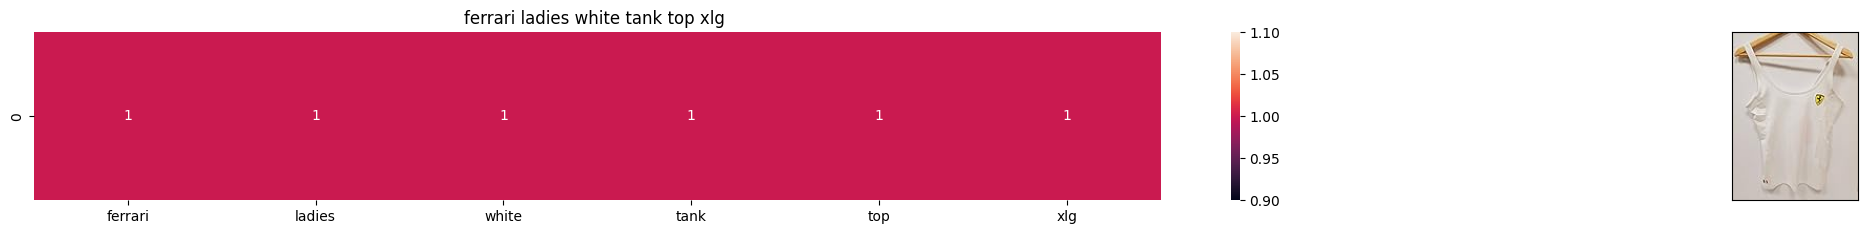

ASIN : B001HWXGYC
Brand: ferrari 
Title: ferrari ladies white tank top xlg 
Euclidean similarity with the query image : 0.0


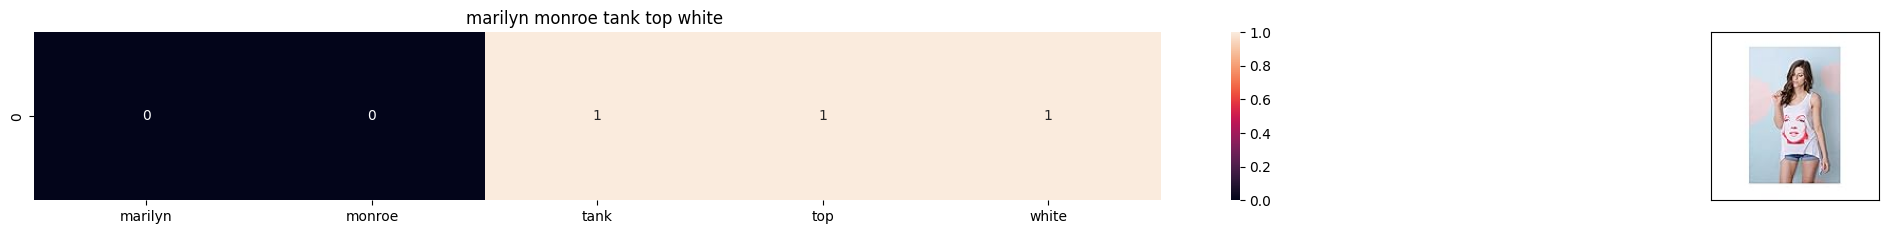

ASIN : B01MTW6DJS
Brand: utopiat 
Title: marilyn monroe tank top white 
Euclidean similarity with the query image : 2.23606797749979


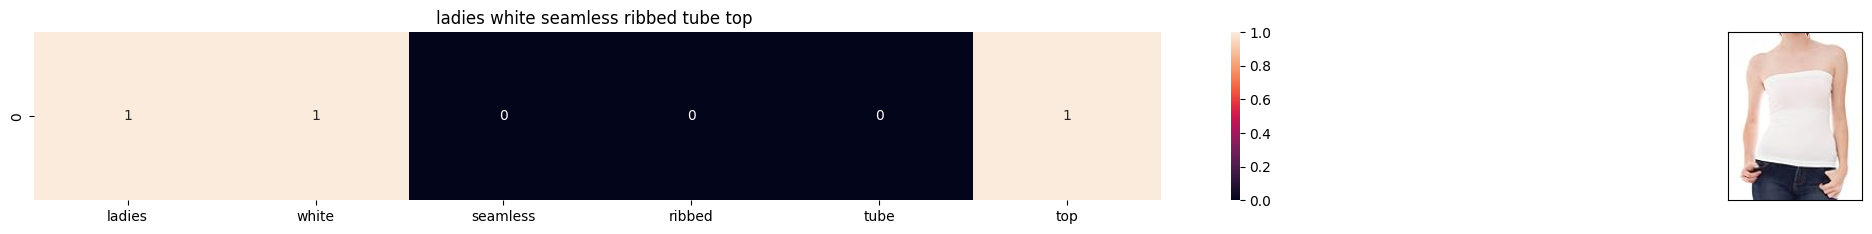

ASIN : B009286M6W
Brand: finebrandshop 
Title: ladies white seamless ribbed tube top 
Euclidean similarity with the query image : 2.449489742783178


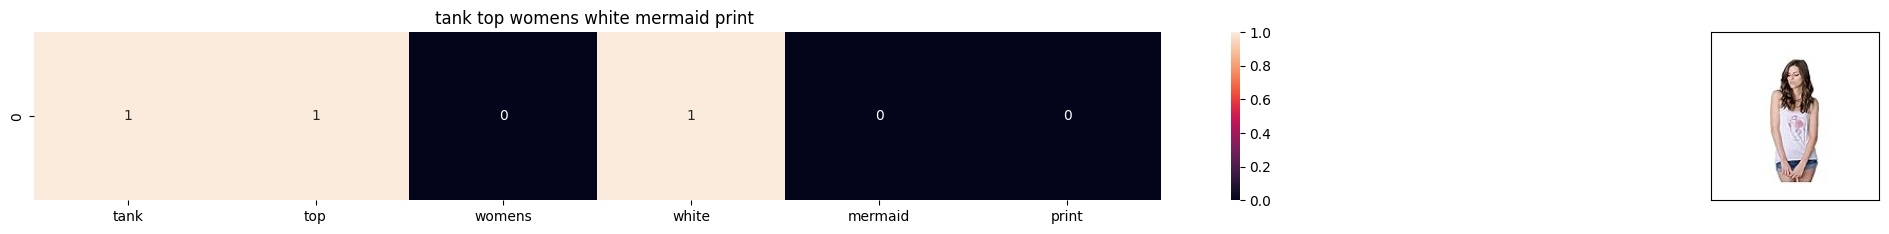

ASIN : B01N1RKW30
Brand: utopiat 
Title: tank top womens white mermaid print 
Euclidean similarity with the query image : 2.449489742783178


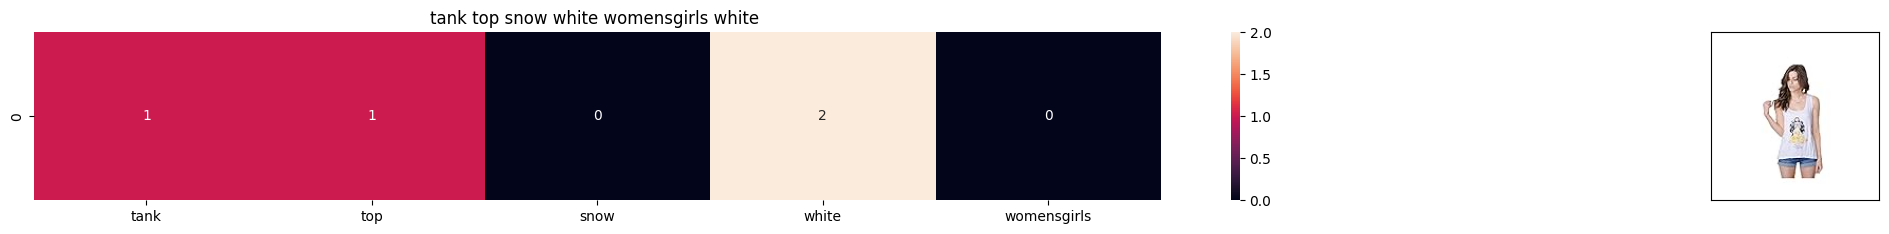

ASIN : B01N1RKIB3
Brand: utopiat 
Title: tank top snow white womensgirls white 
Euclidean similarity with the query image : 2.449489742783178


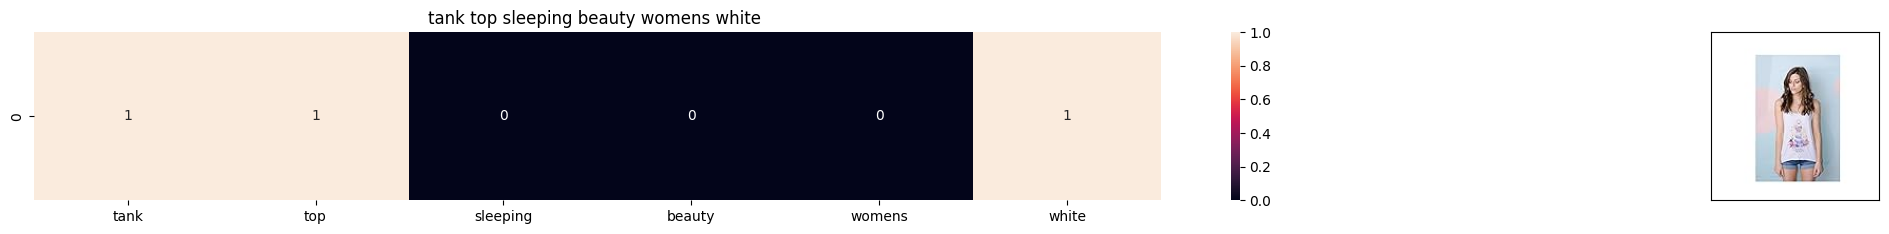

ASIN : B01N9CUQIF
Brand: utopiat 
Title: tank top sleeping beauty womens white 
Euclidean similarity with the query image : 2.449489742783178
Average euclidean distance is  2.0056711581054167


In [ ]:
print('Getting the similar items for document id and number of items')
bag_of_words_model(56, 6)

In [ ]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])
tf_idf_euclidean=[]
def tfidf_model(doc_id, num_results):

    L=[]
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])
    for i in range(0,len(indices)):
        L.append(data['asin'].loc[df_indices[i]])
    return L

In [ ]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])
# tfidf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(courpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# tfidf_title_features[doc_id, index_of_word_in_corpus] = tfidf values of the word in given doc
tf_idf_euclidean=[]
def tfidf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]],data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        tf_idf_euclidean.append(pdists[i])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
    print('Average euclidean distance is',sum(tf_idf_euclidean)/num_results)

In [ ]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

In [ ]:
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [ ]:
idf_euclidean=[]
def idf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'idf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        idf_euclidean.append(pdists[i])
        print ('euclidean distance from the given image :', pdists[i])
        print('='*125)
    print('Average euclidean distance is ',sum(idf_euclidean)/num_results)

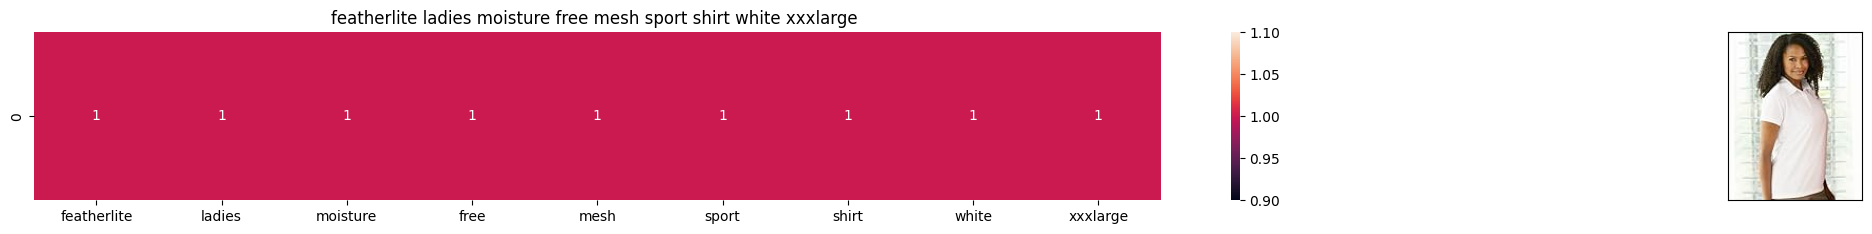

ASIN : B003BSRPB0
Brand : featherlite 
euclidean distance from the given image : 0.0


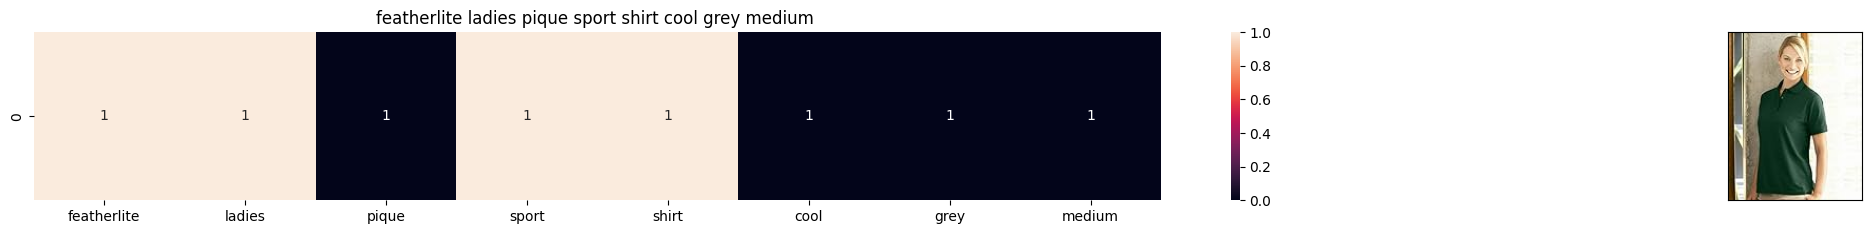

ASIN : B003BSRRS6
Brand : featherlite 
euclidean distance from the given image : 3.0


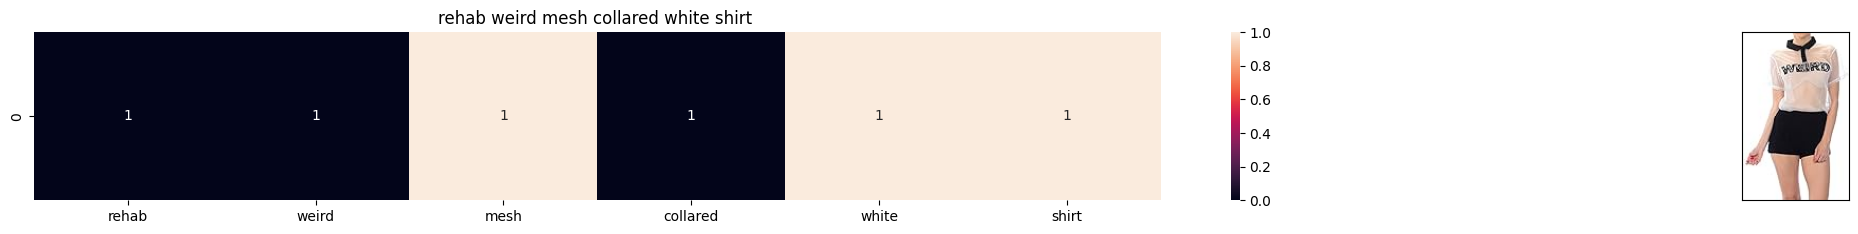

ASIN : B0714FKBQ9
Brand : rehab  large 
euclidean distance from the given image : 3.0


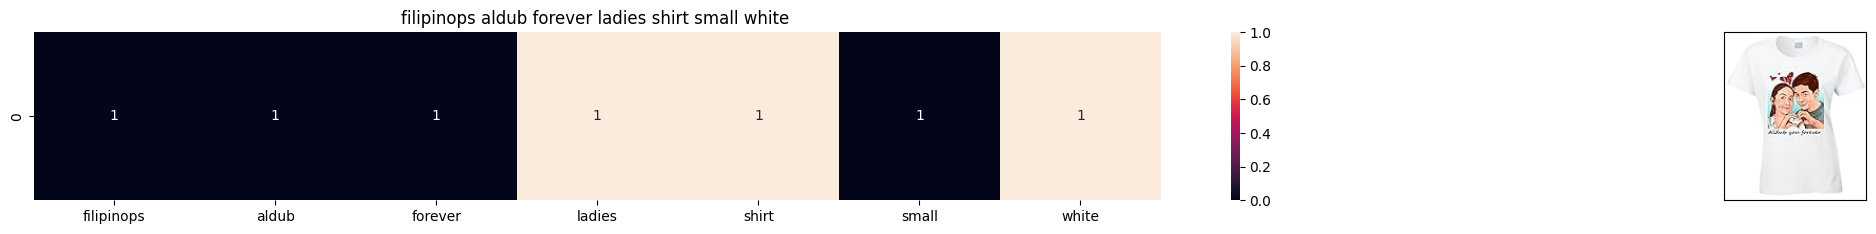

ASIN : B018MQHYJI
Brand : alstyle apparel 
euclidean distance from the given image : 3.1622776601683795


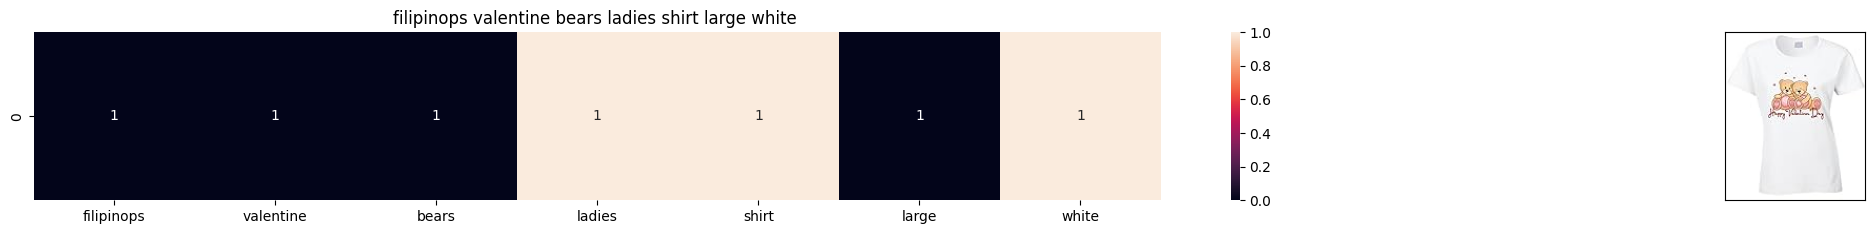

ASIN : B01A3OUPHK
Brand : alstyle apparel 
euclidean distance from the given image : 3.1622776601683795
Average euclidean distance is  2.464911064067352


In [ ]:
idf_model(0,5)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors

In [ ]:
data.columns

Index(['index', 'asin', 'brand', 'color', 'medium_image_url',
       'product_type_name', 'title', 'formatted_price', 'digital'],
      dtype='object')

In [ ]:
sparse_matrix_products = data[["color","brand","product_type_name","formatted_price"]]

In [ ]:
sparse_matrix_products['formatted_price'] = pd.to_numeric(sparse_matrix_products['formatted_price'], errors='coerce')

# Calculate the normalized price
sparse_matrix_products['normalized_price'] = sparse_matrix_products['formatted_price'] - sparse_matrix_products['formatted_price']


In [ ]:
sparse_matrix_products["normalized_price"].describe()

count    8949.0
mean     0.0   
std      0.0   
min      0.0   
25%      0.0   
50%      0.0   
75%      0.0   
max      0.0   
Name: normalized_price, dtype: float64

In [ ]:
sparse_matrix_products.drop("formatted_price",axis=1,inplace=True)

In [ ]:
sparse_matrix_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8949 entries, 0 to 8948
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   color              8949 non-null   object 
 1   brand              8949 non-null   object 
 2   product_type_name  8949 non-null   object 
 3   normalized_price   8949 non-null   float64
dtypes: float64(1), object(3)
memory usage: 279.8+ KB


In [ ]:
sparse_matrix_products = pd.get_dummies(sparse_matrix_products)


In [ ]:
model = NearestNeighbors(n_neighbors=15,
                         metric='cosine',
                         algorithm='brute',
                         n_jobs=-1)
model.fit(sparse_matrix_products)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=15)

In [ ]:
import pickle

# Its important to use binary mode
knnPickle = open('knnpickle_file', 'wb')

# source, destination
pickle.dump(model, knnPickle)

In [ ]:
loaded_model = pickle.load(open('knnpickle_file', 'rb'))

distances,indices=loaded_model.kneighbors(sparse_matrix_products.iloc[query_index,:].values.reshape(1,-1))


EOFError: ignored

In [ ]:
import os
print(os.path.isfile('knnpickle_file'))


True


In [ ]:
loaded_model = pickle.load(open('/content/knnpickle_file', 'rb'))


In [ ]:
query_index = 42  # Replace 42 with the index of the data point you want to query
distances, indices = loaded_model.kneighbors(sparse_matrix_products.iloc[query_index, :].values.reshape(1, -1))


In [ ]:
print(len(distances.flatten()))
M=[]
D=[]
for i in range(0, 10):
    if i == 0:
        print("Recommendation for {0}:\n".format(sparse_matrix_products.index[query_index]))
    else:
        M.append(sparse_matrix_products.index[indices.flatten()[i]])
        D.append(distances.flatten()[i])
        print("{0}: {1}, with distance of {2}".format(i, sparse_matrix_products.index[indices.flatten()[i]], distances.flatten()[i]))

# Now you have recommendations in lists M and D
# You can use M and D as needed for further processing or displaying the recommendations.


15
Recommendation for 42:

1: 7157, with distance of 0.33333333333333315
2: 4705, with distance of 0.33333333333333315
3: 5634, with distance of 0.33333333333333315
4: 30, with distance of 0.33333333333333315
5: 2223, with distance of 0.33333333333333315
6: 8440, with distance of 0.33333333333333315
7: 548, with distance of 0.33333333333333315
8: 1236, with distance of 0.33333333333333315
9: 8566, with distance of 0.33333333333333315


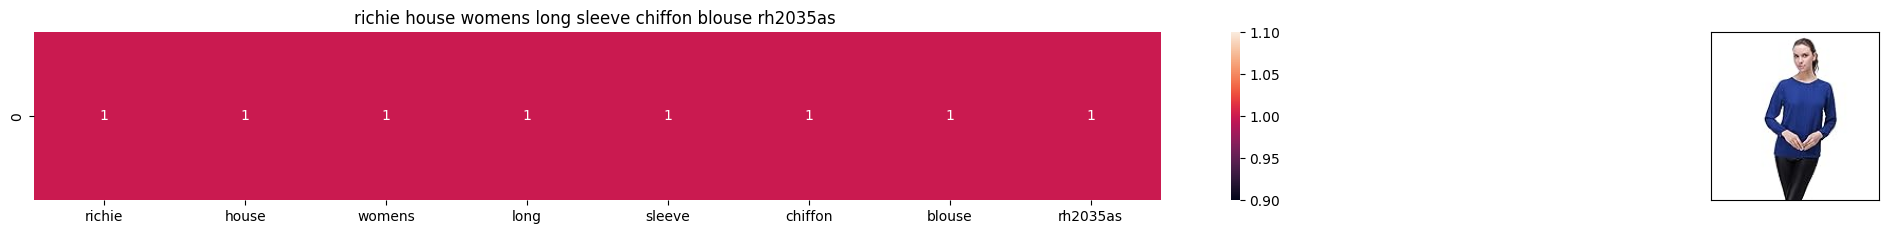

ASIN : B00M3EEAZC
Brand: Richie House
Color: Blue
Price: $11.50
Title: richie house womens long sleeve chiffon blouse rh2035as 
La distance est : 0.33333333333333315


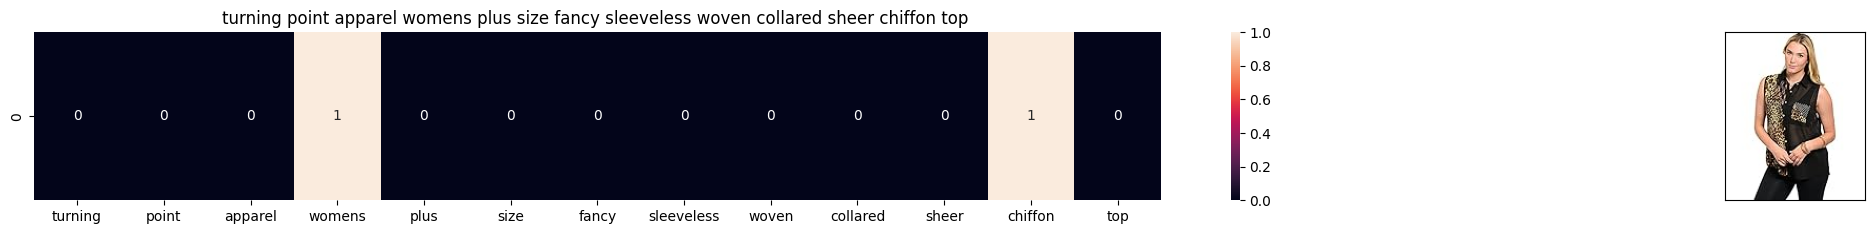

ASIN : B00NVT44J0
Brand: Turning Point Apparel
Color: Black/Beige
Price: $12.50
Title: turning point apparel womens plus size fancy sleeveless woven collared sheer chiffon top 
La distance est : 0.33333333333333315


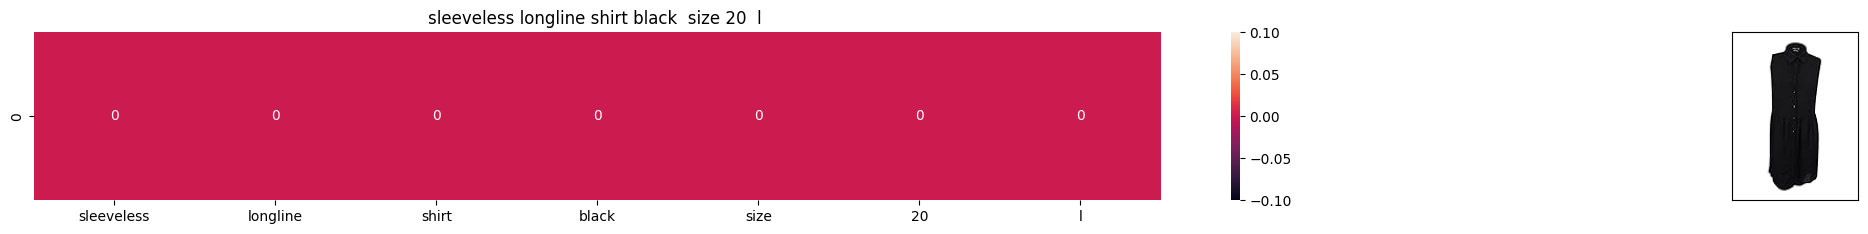

ASIN : B071KCLKXF
Brand: City Chic
Color: Black
Price: $43.45
Title: sleeveless longline shirt black  size 20  l 
La distance est : 0.33333333333333315


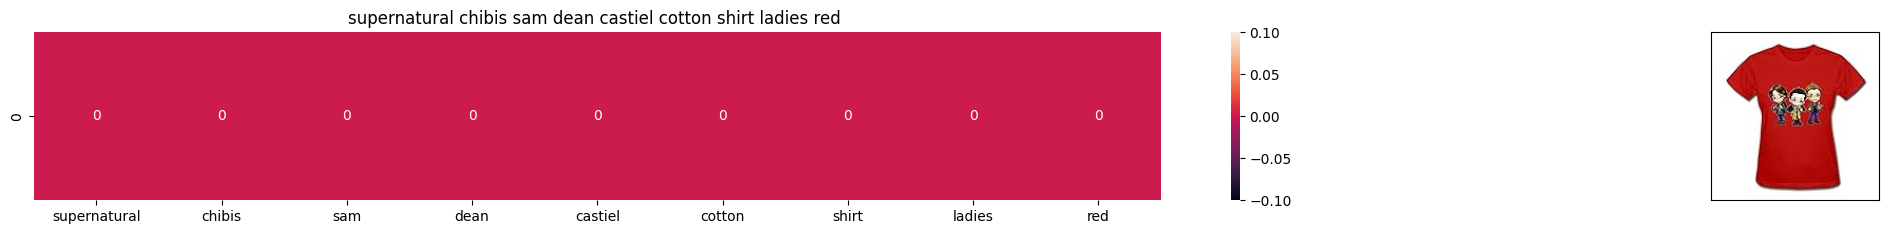

ASIN : B014ICC10C
Brand: FNC7C
Color: Red
Price: $7.91
Title: supernatural chibis sam dean castiel cotton shirt ladies red 
La distance est : 0.33333333333333315


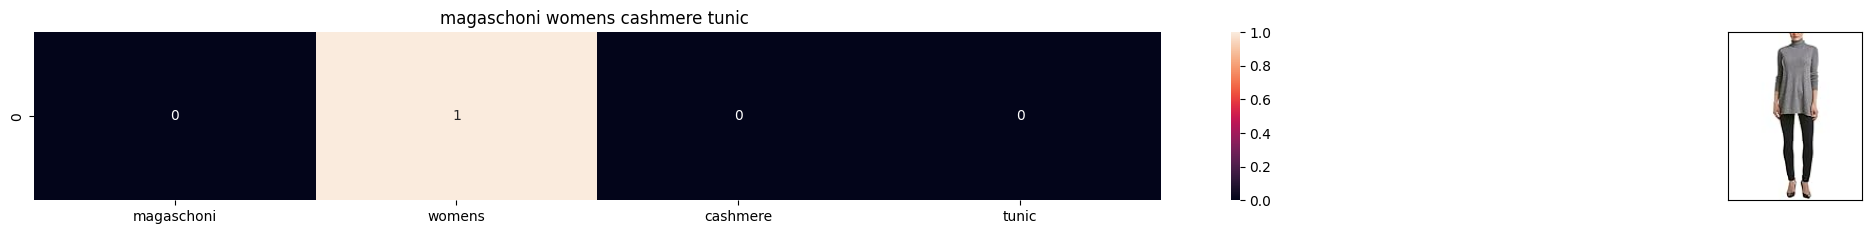

ASIN : B01MY1ZZUS
Brand: Magaschoni
Color: Silver Mouline
Price: $179.99
Title: magaschoni womens cashmere tunic 
La distance est : 0.33333333333333315


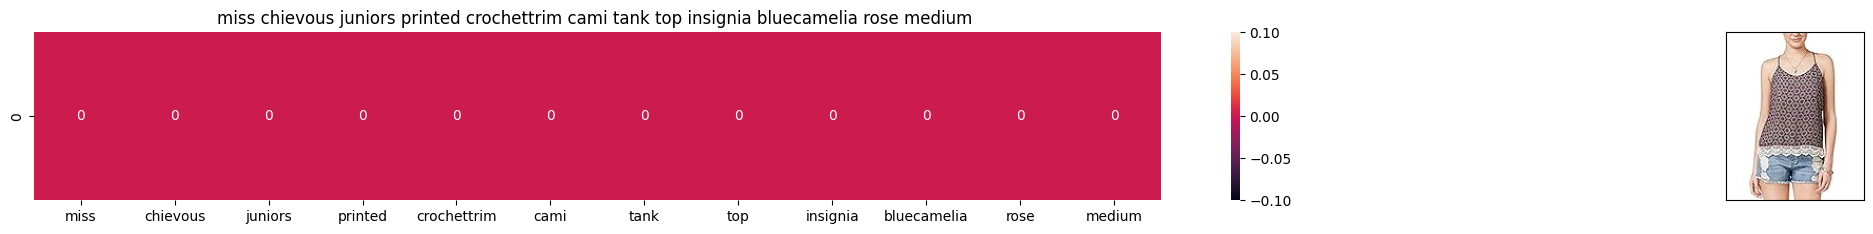

ASIN : B072TBP5FL
Brand: Miss Chievous
Color: Insignia Blue/Camelia Rose
Price: $24.95
Title: miss chievous juniors printed crochettrim cami tank top insignia bluecamelia rose medium 
La distance est : 0.33333333333333315


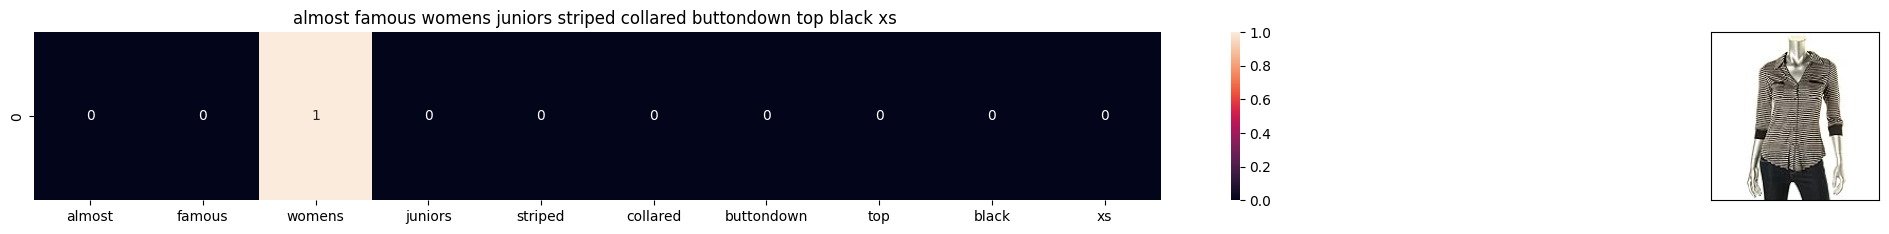

ASIN : B01LOP8RV8
Brand: Almost Famous
Color: Black Taup
Price: $18.99
Title: almost famous womens juniors striped collared buttondown top black xs 
La distance est : 0.33333333333333315


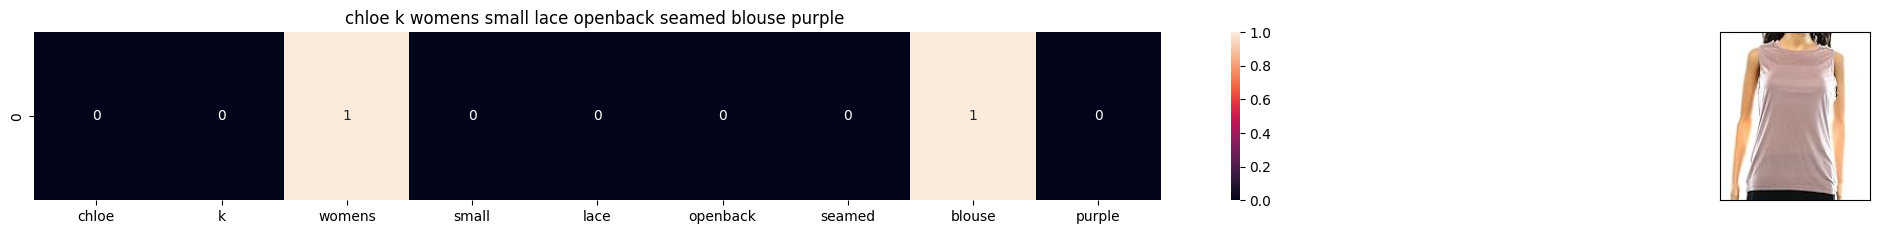

ASIN : B072FN7DT6
Brand: Chloe K.
Color: Purple
Price: $9.99
Title: chloe k womens small lace openback seamed blouse purple 
La distance est : 0.33333333333333315


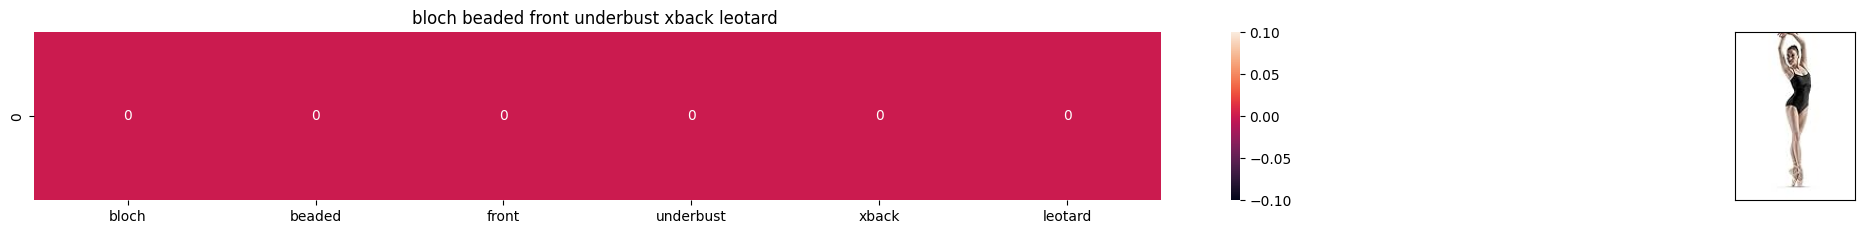

ASIN : B01BN133EO
Brand: Bloch
Color: Black
Price: $30.89
Title: bloch beaded front underbust xback leotard 
La distance est : 0.33333333333333315


In [ ]:
for i in range(0,len(M)):
    get_result(M[i],df['title'].loc[M[0]], df['title'].loc[M[i]], df['medium_image_url'].loc[M[i]], 'bag_of_words')
    print('ASIN :',df['asin'].loc[M[i]])
    print ('Brand:', df['brand'].loc[M[i]])
    print ('Color:', df['color'].loc[M[i]])
    print ('Price:', df['formatted_price'].loc[M[i]])
    print ('Title:', df['title'].loc[M[i]])
    print ("La distance est :", D[i])
    print('='*60)

In [ ]:
euclidean_distance=[]
num_results=20
euclidean_distance.append(sum(bag_of_words_euclidean)/num_results)
euclidean_distance.append(sum(tf_idf_euclidean)/num_results)
euclidean_distance.append(sum(idf_euclidean)/num_results)
x=euclidean_distance
y=[]
for i in range(0,47,3):
    y.append(i)

euclidean_distance

[0.6017013474316251, 0.0, 0.616227766016838]

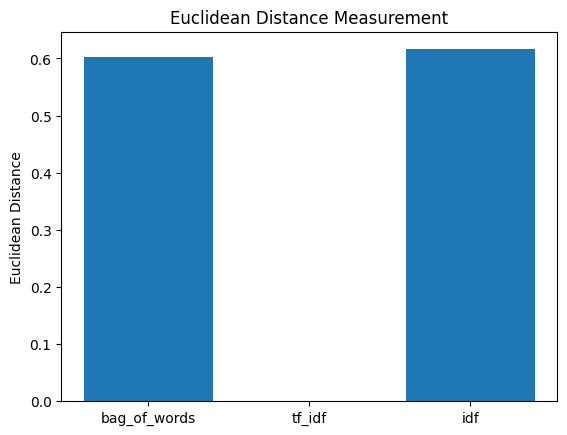

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
objects = ('bag_of_words', 'tf_idf', 'idf')
y_pos = np.arange(len(objects))
plt.bar(objects,x)
plt.ylabel('Euclidean Distance')
plt.title('Euclidean Distance Measurement')
plt.savefig('Comparaison des modeles.png')
plt.show()